In [1]:
from sentence_transformers import SentenceTransformer
from openai import AzureOpenAI
import json
import os
import numpy as np
from numpy import dot
from numpy.linalg import norm
import umap

c:\Users\magottei\source\chat-your-data-intro\notebooks\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
# https://huggingface.co/sentence-transformers/paraphrase-MiniLM-L6-v2
local_model = SentenceTransformer("paraphrase-MiniLM-L6-v2")
# https://learn.microsoft.com/en-us/azure/ai-services/openai/tutorials/embeddings?tabs=python-new%2Ccommand-line
openai_client = AzureOpenAI(
    api_key = os.getenv("AZURE_OPENAI_API_KEY"),
    api_version = "2023-05-15",
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    azure_deployment=os.getenv("AZURE_OPENAI_EMB_DEPLOYMENT")
)

with open("sentences.json", "r") as f:
    sentences = json.load(f)

for sentence in sentences:
    sentence["paraphrase-MiniLM-L6-v2-Embedding"] = local_model.encode([sentence["sentence"]])[0].tolist()
    sentence["ada002-Embedding"] = openai_client.embeddings.create(input = [sentence["sentence"]], model="text-embedding-ada-002").data[0].embedding


In [19]:
with open("sentences.json", "w") as f:
    json.dump(sentences, f)

In [2]:
with open("sentences.json", "r") as f:
    sentences = json.load(f)

In [5]:
sentence_pairs = [(sentences[15], sentences[16]), (sentences[17], sentences[18])]

# https://en.wikipedia.org/wiki/Cosine_similarity
def compute_cosine_similarity(a, b, embedding_name):
    return dot(a[embedding_name], b[embedding_name])/(norm(a[embedding_name])*norm(b[embedding_name]))

local_embedding = "paraphrase-MiniLM-L6-v2-Embedding"
openai_embedding = "ada002-Embedding"
for (a, b) in sentence_pairs:
    print("Sentence 1: ", a["sentence"].replace("\n", " "))
    print("Sentence 2: ", b["sentence"].replace("\n", " "))
    print(f"Cosine Similarity for {local_embedding}", compute_cosine_similarity(a, b, local_embedding))
    print(f"Cosine Similarity for {openai_embedding}", compute_cosine_similarity(a, b, openai_embedding))

Sentence 1:  Ranking  – also called L2, takes a subset of the top L1 results and computes higher quality relevance scores to reorder the result set.
Sentence 2:  The L2 can improve the L1's ranking because it applies more computational power to each result.
Cosine Similarity for paraphrase-MiniLM-L6-v2-Embedding 0.7235808721142946
Cosine Similarity for ada002-Embedding 0.8894192997535683
Sentence 1:  The L2 ranker can only reorder what the L1 already found – if the L1 missed an ideal document, the L2 can't fix that.
Sentence 2:  L2 ranking is critical for RAG applications to make sure the best results are in the top positions. 
Cosine Similarity for paraphrase-MiniLM-L6-v2-Embedding 0.3766854412030537
Cosine Similarity for ada002-Embedding 0.8453031276167078


<Axes: >

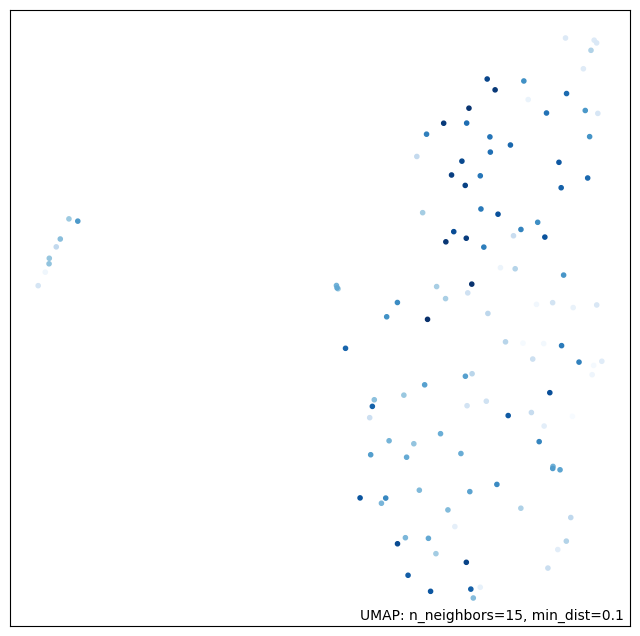

In [55]:
# https://pair-code.github.io/understanding-umap/
# https://umap-learn.readthedocs.io/en/latest/plotting.html
local_mapper = umap.UMAP().fit([sentence[local_embedding] for sentence in sentences])
umap.plot.points(local_mapper, values=np.array(range(len(sentences))))

<Axes: >

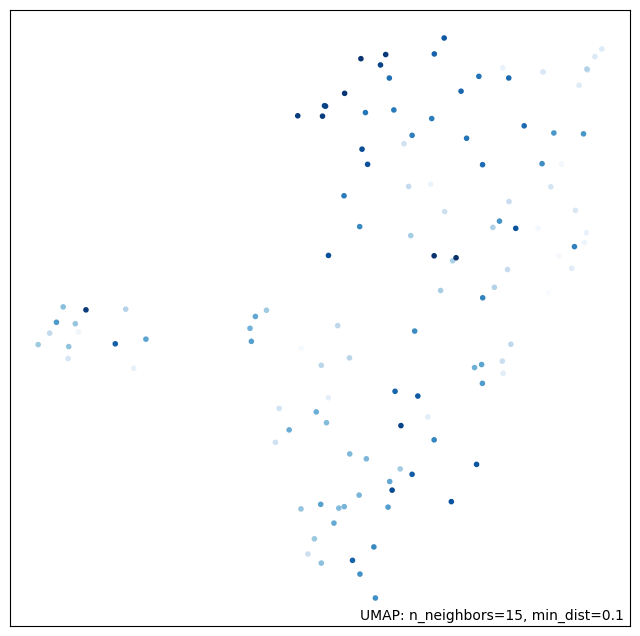

In [56]:
openai_mapper = umap.UMAP().fit([sentence[openai_embedding] for sentence in sentences])
umap.plot.points(openai_mapper, values=np.array(range(len(sentences))))